# Group Delay Function

This note follows [1].


## Definition

**The group delay function is the negative derivative of the phase spectra.**

$$\tau(\omega) = -\frac{d\theta(\omega)}{d\omega}$$

Alternatively, it is the negative imaginary part of the derivative of the log spectra.

$$\tau(\omega) = -Im\{\frac{dlog(X(\omega))}{d\omega}\} = \frac{X_r(\omega)Y_r(\omega)+X_i(\omega)Y_i(\omega)}{|X(\omega)|^2}$$

where $r, i$ denote real and imaginary parts, respectively, and

$$nx(n) \Longleftrightarrow Y(\omega)$$

Finally, the group delay function is also the Fourier transform of the complex cepstrum liftered by a ramp function.

$$\tau(\omega) = \sum_{n=0}^\infty nc(n)cos(n\omega)$$

## Problem with the group delay function

The fraction definition is typically how the group delay function is implemented. However, it could be problematic when the denominator $|X(\omega)|^2$ is small. This happens when any zero of the z-transform of $X(\omega)$ is close to the unit circle. The figure below illustrates the loss of dynamic range of the response at the formant when existing zeros produce peaky responses.

![Group delay functions when zeros are close to the UC](https://rrzone.piwigo.com/_datas/h/d/y/hdynxags0j/i/uploads/h/d/y/hdynxags0j//2019/11/19/20191119044244-6b16d50f-la.png)

## Group delay function using poles and zeros

If a signal can be represented as a series of poles and zeros, we can compute the GDF by first computing the complex cepstrum using the Z-transform method, obtain the odd function of it, and take the real part of the DTFT.

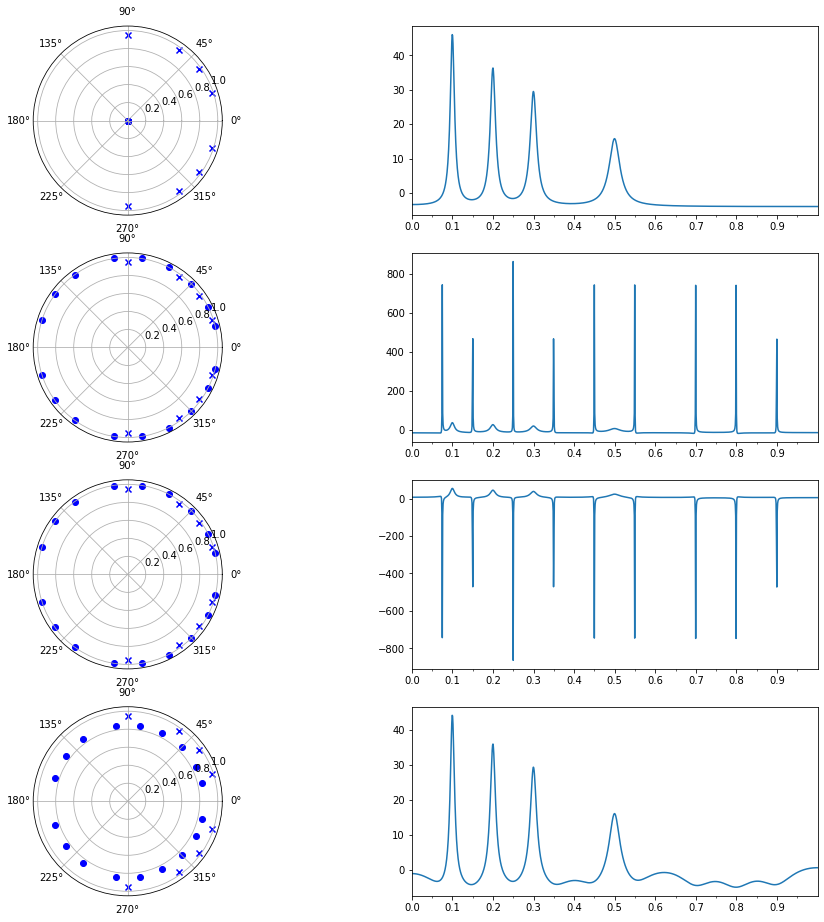

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from audlib.sig.cepstral import zp2ccep
from audlib.plot import magresp
import numpy as np
from numpy.fft import rfft, irfft

NFFT = 2048
TWOPI = 2*np.pi

def gdfpz(czeros, rzeros, cpoles, rpoles, gain, n):
    ccep = zp2ccep(czeros, rzeros, cpoles, rpoles, gain, n)
    dd = .5*(ccep-ccep[::-1])
    liftered = dd[n-1:]*np.arange(n)  # only right-sided is needed
    return rfft(2*liftered).real

zphases = np.array([.075, .15, .25, .35, .45, .55, .7, .8, .9])
pphases = np.array([.1, .2, .3, .5])  # in terms of pi
pmags = .99*np.array([.99, .985, .98, .96])

fig = plt.figure(figsize=(16,16))
for ii, zmag in enumerate((0, 1.001, .999, .85)):
    zmags = zmag*np.ones_like(zphases)
    ax = fig.add_subplot(int(f'42{2*ii+1}'), projection='polar')
    ax.scatter(zphases*np.pi, zmags, color='b', marker='o')
    ax.scatter(-zphases*np.pi, zmags, color='b', marker='o')  # always assume conjugate pairs
    ax.scatter(pphases*np.pi, pmags, color='b', marker='x')
    ax.scatter(-pphases*np.pi, pmags, color='b', marker='x')  # always assume conjugate pairs
    ax.set_ylim(0, 1.05)
    ax = fig.add_subplot(int(f'42{2*ii+2}'))
    ax.plot(np.arange(NFFT//2+1)/(NFFT//2+1),
            gdfpz((zmags, zphases), np.array([]), (pmags, pphases), np.array([]), 1, NFFT))

    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, 1, .1)
    minor_ticks = np.arange(0, 1, .05)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)

    # And a corresponding grid
    ax.grid(which='both')

    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_xlim(0, 1)

## Experiments using real speech signals

I'm going to try the group delay function on the real speech signals, starting with the 'ee' sound in 'dee' of "Welcome to DSP1."

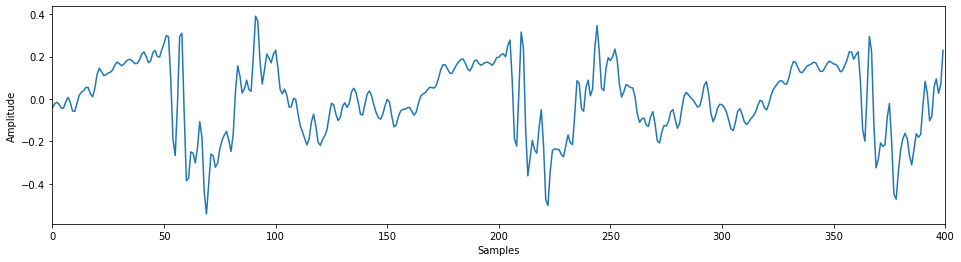

In [2]:
from audlib.quickstart import welcome

STARTPOS = 8000
WINDOW_LENGTH = .025  # in seconds

sig, sr = welcome()
wsize = int(WINDOW_LENGTH*sr)
eesig = sig[STARTPOS:STARTPOS+wsize]  # a segment of 'ee' sound in 'dee'

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(eesig)
ax.set_xlim(0, wsize)
ax.set_xlabel('Samples'); ax.set_ylabel('Amplitude')
plt.show()

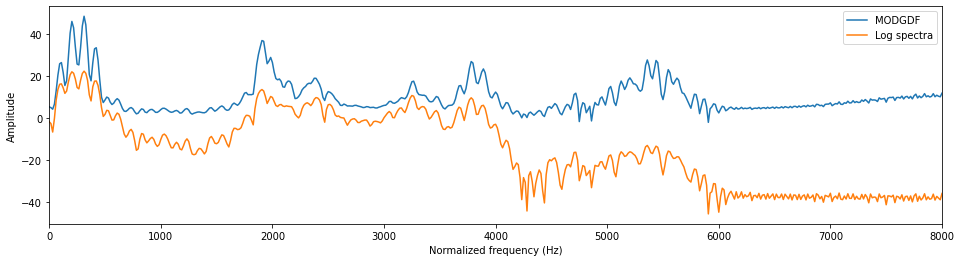

In [3]:
from audlib.sig.window import hamming
from audlib.sig.util import nextpow2, fftfirfreqz
from audlib.sig.cepstral import ccep_zt, rcep_dft
from audlib.sig.spectral import logmag
from numpy.fft import rfft


def gdf_naive(sig, n):
    x = rfft(sig, n)
    y = rfft(sig*np.arange(len(sig)), n)
    return (x.real*y.real + x.imag*y.imag) / (x.real**2 + x.imag**2)


def gdf(sig, n):
    """Group delay function.
    
    Parameters
    ----------
    sig: numpy.ndarray
        Time-domain signal to be processed.
    nfft: int, None
        DFT size. Default to len(sig).

    """
    ccep = ccep_zt(sig, n)
    dd = .5*(ccep-ccep[::-1])[n-1:]  # only right-sided is needed
    #dd[30:] = 0  # low-pass lifter
    return rfft(2*dd*np.arange(n), n).real


def modgdf(sig, n, ncep=8, alpha=.4, gamma=.9):
    """Modified group delay function.
    
    Parameters
    ----------
    sig: numpy.ndarray
        Time-domain signal to be processed

    """
    def cepsmooth(spec):
        cep = irfft(logmag(spec), n)
        cep[ncep:len(cep)-(ncep-1)] = 0
        return np.exp(rfft(cep, n).real)
        
    x = rfft(sig, n)
    y = rfft(sig*np.arange(len(sig)), n)
    tau = (x.real*y.real + x.imag*y.imag) / cepsmooth(np.abs(x))**(2*gamma)
    gdf = np.abs(tau)**alpha
    gdf[tau < 0] *= -1

    return gdf


nfft = max(1024, nextpow2(len(eesig)))
wind = hamming(wsize)
ww, eespec = fftfirfreqz(wind*eesig, nfft)

fig, ax = plt.subplots(figsize=(16, 4))
# uncomment to see the huge dynamic range of raw GDF
#ax.plot(ww[:(nfft//2+1)]*sr/2, gdf(wind*eesig, nfft), label='GDF')
#ax.plot(ww[:(nfft//2+1)]*sr/2, gdf_naive(wind*eesig, nfft), label='GDF-naive')
ax.plot(ww[:(nfft//2+1)]*sr/2, modgdf(wind*eesig, nfft, 6), label='MODGDF')
ax.plot(ww[:(nfft//2+1)]*sr/2, 20*np.log10(np.abs(eespec[:(nfft//2+1)])), label=r'Log spectra')
ax.set_xlim(0, sr/2)
#ax.set_ylim(-50, 30)
ax.set_xlabel(r'Normalized frequency (Hz)'); ax.set_ylabel('Amplitude')
plt.legend()
plt.show()

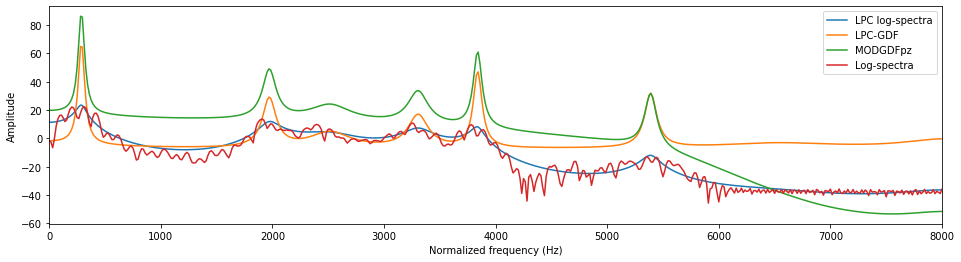

In [4]:
# Do the group delay function on the LPC spectra
from audlib.sig.temporal import lpc_parcor, ref_is_stable, lpcerr
from audlib.sig.temporal import ref2pred, pred2poly
from audlib.sig.util import fftfreqz
from audlib.sig.cepstral import roots, p2ccep, zp2ccep

LPC_ORDER = 16  # or anything reasonable


def lpcgdf(sig, order=14, n=None, lifter=False):
    """Group delay function on the LPC spectra.
    
    Parameters
    ----------
    sig: numpy.ndarray
        Time-domain signal to be processed.
    order: int, 14
        LPC order.
    nfft: int, None
        DFT size. Default to len(sig).

    """
    xks, xgain = lpc_parcor(sig, order)
    assert ref_is_stable(xks), "Unstable system!"
    xpolys = pred2poly(ref2pred(xks))
    cpoles, rpoles, gain = roots(xpolys)
    ccep = p2ccep(cpoles, rpoles, xgain/gain, n)
    if lifter:
        ccep *= np.exp(-np.arange(n)**2/(2*30**2))

    return rfft(ccep*np.arange(n), n).real
    

def modgdfpz(sig, order, n, fac=1.2):
    pks, pgain = lpc_parcor(sig, order)
    assert ref_is_stable(pks), "Unstable system!"
    alphas = ref2pred(pks)
    cpoles, rpoles, _ = roots(pred2poly(alphas))
    wsig = lpcerr(sig, alphas, pgain)
    (cmags, cphases), rzeros, zgain = roots(wsig)

    # manually push zeros away from the UC
    cmags[np.logical_and(cmags < 1, cmags > 1/fac)] /= fac
    cmags[np.logical_and(cmags > 1, cmags < fac)] *= fac
    rzeros[np.logical_and(np.abs(rzeros) < 1, np.abs(rzeros) > 1/fac)] /= fac
    rzeros[np.logical_and(np.abs(rzeros) > 1, np.abs(rzeros) < fac)] *= fac

    ccep = zp2ccep((cmags, cphases), rzeros, cpoles, rpoles, pgain*zgain, n)[n-1:]

    return rfft(ccep*np.arange(n), n).real


eelpcgdf = lpcgdf(wind*eesig, LPC_ORDER, nfft, lifter=False)
ks, gain = lpc_parcor(wind*eesig, LPC_ORDER)
polys = pred2poly(ref2pred(ks))
_, eelpcspec = fftfreqz([gain], polys, nfft)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(ww[:(nfft//2+1)]*sr/2, 20*np.log10(np.abs(eelpcspec[:(nfft//2+1)])), label='LPC log-spectra')
ax.plot(ww[:(nfft//2+1)]*sr/2, eelpcgdf, label='LPC-GDF')
ax.plot(ww[:(nfft//2+1)]*sr/2, modgdfpz(wind*eesig, LPC_ORDER, nfft, 1.4), label='MODGDFpz')
ax.plot(ww[:(nfft//2+1)]*sr/2, 20*np.log10(np.abs(eespec[:(nfft//2+1)])), label='Log-spectra')
ax.set_xlim(0, sr/2)
ax.set_xlabel(r'Normalized frequency (Hz)'); ax.set_ylabel('Amplitude')
plt.legend()
plt.show()

## References

[1]: Hegde, R. M., Murthy, H. A., & Gadde, V. R. R. (2006). Significance of the modified group delay feature in speech recognition. IEEE Transactions on Audio, Speech, and Language Processing, 15(1), 190-202.

[2]: Rabiner, L. R., & Schafer, R. W. (2011). Theory and applications of digital speech processing (Vol. 64). Upper Saddle River, NJ: Pearson.